In [16]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
import datetime
from datetime import timedelta
from datetime import datetime

In [17]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    plt.figure(figsize=(12, 6))
    
    if type(y) is list:
        for y_curr in y:
            plt.plot(x[start:end], y_curr[start:end], format)
    else:
        plt.plot(x[start:end], y[start:end], format)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend:
        plt.legend(legend)
    plt.title(title)
    plt.grid(True)
    plt.show()

# Get The Dataset

In [18]:
# Initialize lists
dates = []
sales = []
spend = []

# Open CSV file
with open('../Dataset/dummy_dataset.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)  # Skip header
    for row in reader:
        dates.append(datetime.strptime(row[0], '%Y-%m-%d'))
        sales.append(float(row[1]))
        spend.append(float(row[2]))

# Read the CSV file into a DataFrame
df = pd.read_csv('../Dataset/dummy_dataset.csv')

# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Convert lists to numpy arrays
time = np.array(dates)
sales_series = np.array(sales)
spend_series = np.array(spend)

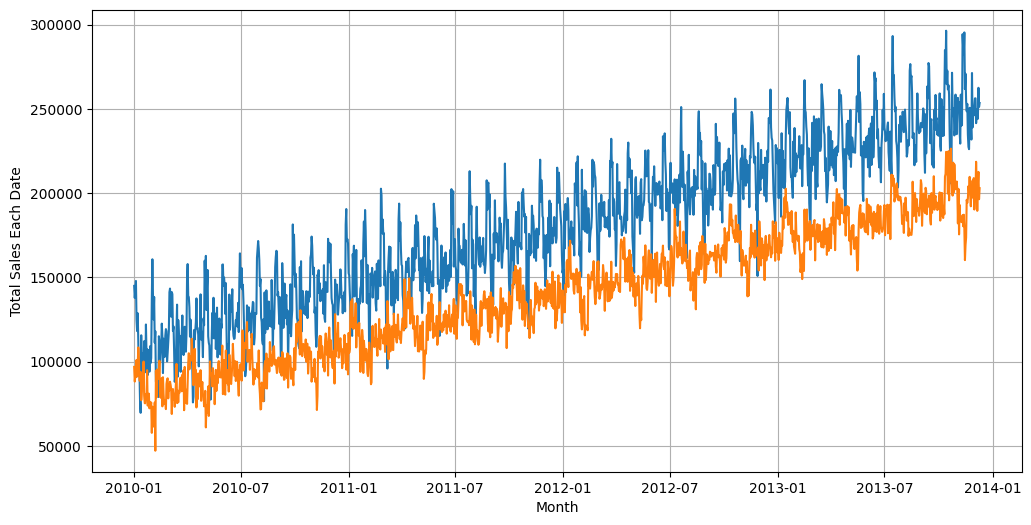

In [19]:
# Preview the data
plot_series(time, [sales_series, spend_series], xlabel='Month', ylabel='Total Sales Each Date')

In [20]:
# Split the data
ROW_COUNT = len(sales_series)
SPLIT_TIME = int(0.7 * ROW_COUNT)

time_train = time[:SPLIT_TIME]
x_train_sales = sales_series[:SPLIT_TIME]
x_train_spend = spend_series[:SPLIT_TIME]

time_valid = time[SPLIT_TIME:]
x_valid_sales = sales_series[SPLIT_TIME:]
x_valid_spend = spend_series[SPLIT_TIME:]

print(f"x_train_sales shape: {x_train_sales.shape}")
print(f"x_valid_sales shape: {x_valid_sales.shape}")

x_train_sales shape: (1007,)
x_valid_sales shape: (433,)


In [21]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """
    Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer (int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [22]:
WINDOW_SIZE = 90
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

In [23]:
# Combine sales and spend into a single multivariate series
x_train_multivariate = np.column_stack((x_train_sales, x_train_spend))
x_valid_multivariate = np.column_stack((x_valid_sales, x_valid_spend))

# Generate the dataset windows
train_set = windowed_dataset(x_train_multivariate, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER_SIZE)

In [24]:
from tensorflow.keras.layers import Conv1D, Dense, LSTM, Bidirectional, Dropout, SimpleRNN, GRU, MaxPooling1D, Flatten

# Build the Model

model = tf.keras.models.Sequential([
    Conv1D(filters=32, kernel_size=3, activation="relu", padding='causal', input_shape=[WINDOW_SIZE, 2]),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation="relu", padding='causal'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation="relu", padding='causal'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(10, activation="relu"),
    Dense(2),
])

In [25]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

In [26]:
# Set the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer='adam',
              metrics=["mae"])

In [34]:
history = model.fit(train_set, epochs=100)

Epoch 1/100
29/29 [==============================] - 1s 5ms/step - loss: 7479.2617 - mae: 7479.7612
Epoch 2/100
29/29 [==============================] - 0s 4ms/step - loss: 7486.8452 - mae: 7487.3447
Epoch 3/100
29/29 [==============================] - 0s 4ms/step - loss: 7623.5493 - mae: 7624.0493
Epoch 4/100
29/29 [==============================] - 0s 6ms/step - loss: 7726.7539 - mae: 7727.2539
Epoch 5/100
29/29 [==============================] - 0s 4ms/step - loss: 7478.5464 - mae: 7479.0464
Epoch 6/100
29/29 [==============================] - 0s 3ms/step - loss: 7622.0820 - mae: 7622.5820
Epoch 7/100
29/29 [==============================] - 0s 4ms/step - loss: 7537.9404 - mae: 7538.4404
Epoch 8/100
29/29 [==============================] - 0s 3ms/step - loss: 7455.6440 - mae: 7456.1440
Epoch 9/100
29/29 [==============================] - 0s 3ms/step - loss: 7469.7432 - mae: 7470.2422
Epoch 10/100
29/29 [==============================] - 0s 3ms/step - loss: 7468.4082 - mae: 7468.9082

In [35]:
# Generate the validation dataset windows
valid_set = windowed_dataset(x_valid_multivariate, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER_SIZE)

# Evaluate the model on the training set
train_mae = model.evaluate(train_set)
print(f"Training MAE: {train_mae[1]}")

# Evaluate the model on the validation set
valid_mae = model.evaluate(valid_set)
print(f"Validation MAE: {valid_mae[1]}")

29/29 [==============================] - 0s 4ms/step - loss: 7483.6792 - mae: 7484.1792
Training MAE: 7484.17919921875
11/11 [==============================] - 0s 3ms/step - loss: 11011.6582 - mae: 11012.1582
Validation MAE: 11012.158203125


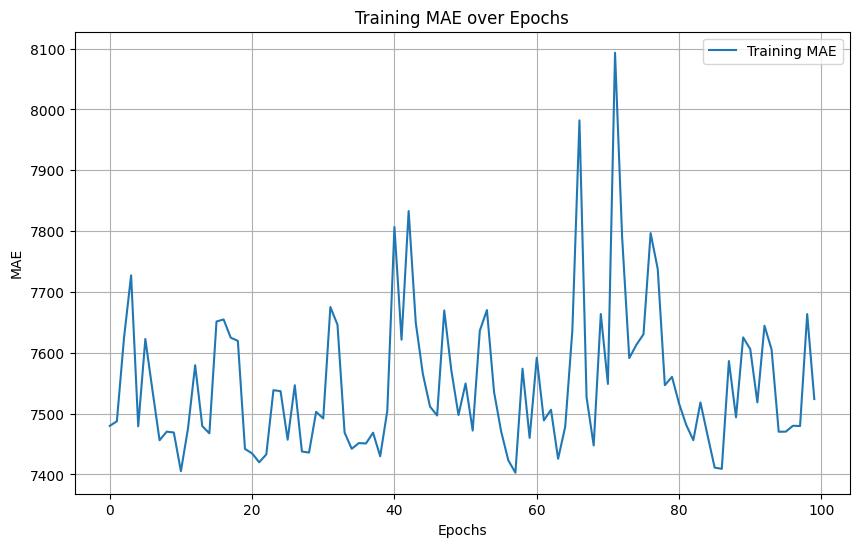

In [36]:
# Plot the training and validation MAE over epochs
mae = history.history['mae']
epochs = range(len(mae))

plt.figure(figsize=(10, 6))
plt.plot(epochs, mae, label='Training MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title('Training MAE over Epochs')
plt.grid(True)
plt.show()

14/14 [==============================] - 0s 4ms/step


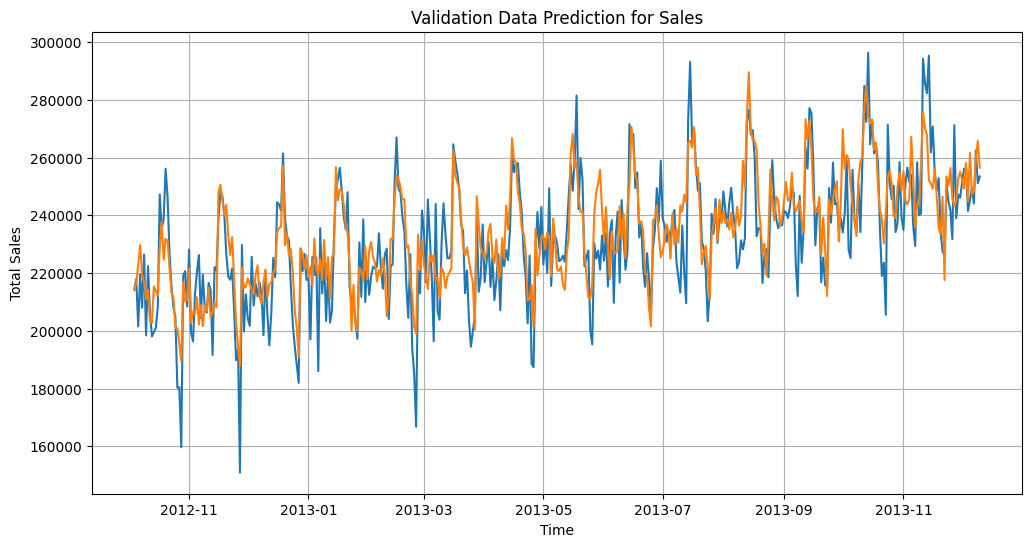

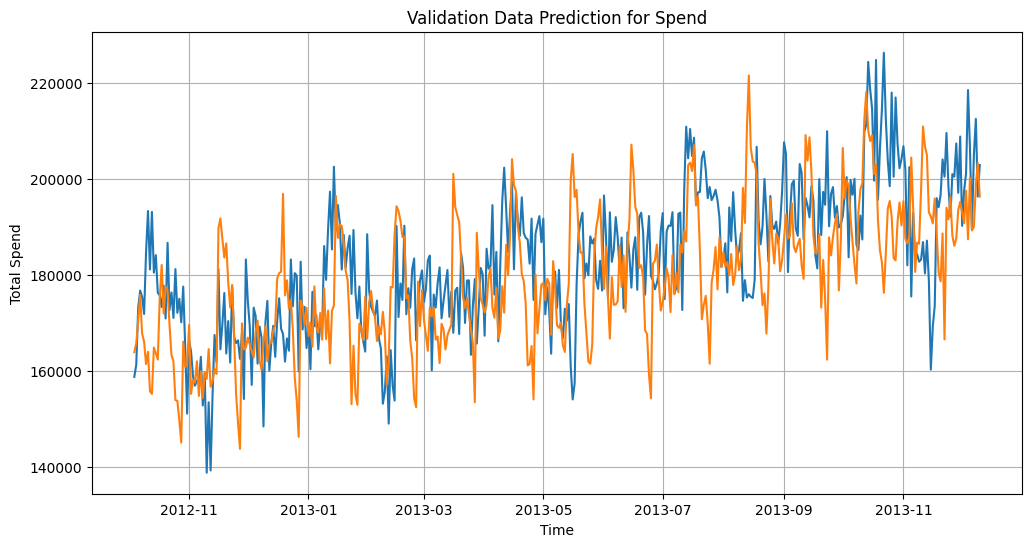

In [37]:
def model_forecast_multivariate(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows for multivariate data

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

# Combine sales and spend series into a single multivariate series
multivariate_series = np.vstack((sales_series, spend_series)).T

# Reduce the original series
forecast_series = multivariate_series[SPLIT_TIME - WINDOW_SIZE: -1]

# Use helper function to generate predictions
forecast = model_forecast_multivariate(model, forecast_series, WINDOW_SIZE, BATCH_SIZE)

# Plot the resultsSimpleRNN(30, activation='relu', return_sequences=True),
results_sales = forecast[:, 0]
results_spend = forecast[:, 1]

# Plot the sales and spend predictions
plot_series(time_valid, [x_valid_multivariate[:, 0], results_sales], title="Validation Data Prediction for Sales", xlabel="Time", ylabel="Total Sales")
plot_series(time_valid, [x_valid_multivariate[:, 1], results_spend], title="Validation Data Prediction for Spend", xlabel="Time", ylabel="Total Spend")


In [38]:
# Save the model
model.save('../ModelResult/dummy_dataset.h5')

In [39]:
def forecast_future(days=30):
    ### Prepare Data for Prediction
    max_date = df['Date'].max()
    future_dates = np.array([max_date + timedelta(days=i) for i in range(days)])
    future_sales = np.zeros((days, 2))  # Initialize array to store predicted values

    x_input = x_valid_multivariate[-WINDOW_SIZE:]  # Use last WINDOW_SIZE days of validation data as input
    x_input = np.column_stack((x_input[:, 0], x_input[:, 1]))  # Reshape input data

    ### Make Predictions
    for i in range(days):
        x_input = x_input.reshape((1, WINDOW_SIZE, 2))  # Reshape input data for model
        prediction = model.predict(x_input)  # Make prediction
        future_sales[i] = prediction  # Store predicted values
        x_input = np.roll(x_input, -1)  # Roll input data to make next prediction
        x_input[:, -1, :] = prediction  # Update input data with predicted values

    ### Plot the results
    results_sales = forecast[:, 0]
    results_spend = forecast[:, 1]

    ### Create a figure with two subplots
    fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    ### Plot validation data and predictions on the first part of each subplot
    ax[0].plot(time_valid, x_valid_multivariate[:, 0], label='Validation Sales')
    ax[0].plot(time_valid, results_sales, label='Predicted Sales')
    ax[0].set_title('Validation Data Prediction for Sales')
    ax[0].set_ylabel('Total Sales')
    ax[0].legend()

    ax[1].plot(time_valid, x_valid_multivariate[:, 1], label='Validation Spend')
    ax[1].plot(time_valid, results_spend, label='Predicted Spend')
    ax[1].set_title('Validation Data Prediction for Spend')
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('Total Spend')
    ax[1].legend()

    ### Plot predicted values for next 365 days on the same figure
    ax[0].plot(future_dates, future_sales[:, 0], label='Predicted Sales (Next 365 Days)')
    ax[1].plot(future_dates, future_sales[:, 1], label='Predicted Spend (Next 365 Days)')

    plt.tight_layout()
    plt.show()

1/1 [==============================] - 0s 14ms/step


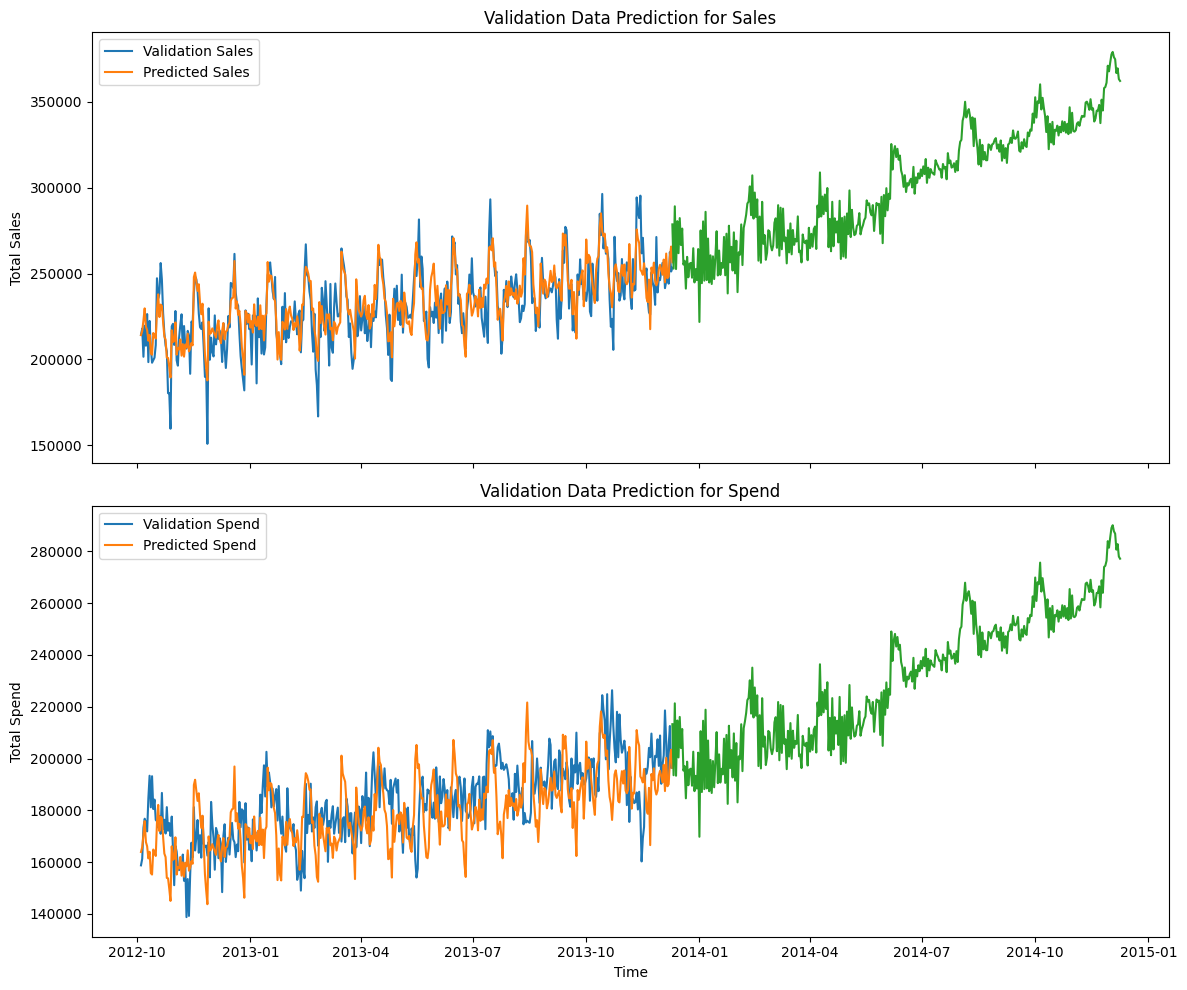

In [40]:
from tensorflow.keras.models import load_model

model = load_model('../ModelResult/dummy_dataset.h5')

forecast_future(365)